Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

![CYP](https://pubs.acs.org/cms/10.1021/acs.chemrestox.3c00305/asset/images/medium/tx3c00305_0006.gif)

## Background
Cytochrome P450 (CYP) enzymes are membrane-bound hemeproteins that play a key role in metabolism of drugs and xenobiotics. Most drugs are mainly metabolized by cytochrome P450 (CYP450), which can lead to drug–drug interactions (DDI). Specifically, time-dependent inhibition (TDI) of CYP3A4 isoenzyme has been associated with clinically relevant DDI. To overcome potential DDI issues, high-throughput in vitro assays were established to assess the TDI of CYP3A4 during the discovery and lead optimization phases.

## Assay information
To assess time-dependent inhibition (TDI), inactivation rate constants (kobs values) were determined. For this purpose, test articles (10 μM) were dispensed to 96-well plates, and the preincubation was started by the addition of human liver microsomes supplemented with reduced nicotinamide adenine dinucleotide phosphate (NADPH). After 0, 7, 16, and 32 min, the residual CYP3A activity was determined by the addition of midazolam (including d4-1-hydroxy-midazolam as internal standard) and incubated for six additional minutes before being stopped by the addition of acetonitrile. The supernatants were analyzed for the CYP3A4 selective metabolites 1-hydroxymidazolam and d4-1-hydroxymidazolam using liquid chromatography–mass spectrometry (LC–MS). The time-dependent CYP3A enzyme activity was calculated using the normalized AREA-ratios of 1-hydroxymidazolam to the internal standard and plotted over the preincubation time. The first-order inactivation rate constant kobs was determined by a 1-parameter fit using a range of 80% and a background of 20%. The percentage of reversible inhibition (%inh-rev) was calculated by the AREA-ratio at a preincubation time of 0 min in relation to the AREA-ratio of the control containing dimethyl sulfoxide (DMSO) only. In the case of a strong reversible inhibition (%inh-rev >50%), no kobs values were calculated.

## Description of readout:
- **log_kobs**:  Log-transformed(base 10) inactivation rate($K_{obs}$). 

## Data resource

**Raw data**: 
- Training set: https://pubs.acs.org/doi/suppl/10.1021/acs.chemrestox.3c00305/suppl_file/- tx3c00305_si_002.xlsx 
- Test set: https://pubs.acs.org/doi/suppl/10.1021/acs.chemrestox.3c00305/suppl_file/tx3c00305_si_003.xlsx

**Processed data**: gs://polaris-public/polaris-recipes/org-novatis/CYP/data/raw/train_test.parquet

## Curation reproducibility
The curation process in this notebook can be reproduced by command line:

```shell
auroris curate org-Novartis/CYP/curation_config.json org-Novartis/CYP
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[2]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [2]:
org = "novatis"
data_name = "CYP"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"


# Load the data
source_data_path = (
    "gs://polaris-public/polaris-recipes/org-novatis/CYP/data/raw/train_test.parquet"
)
data = pd.read_parquet(source_data_path)

### Run preliminary curation for data inspection

In [3]:
data_cols = ["log_kobs", "pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"]
mol_col = "Structure"

In [4]:
data.isna().any(axis=0)

Structure               False
log_kobs                False
pIC50_CYP3A4             True
pIC50_CYP2C9             True
pIC50_CYP2D6             True
split                   False
kobs                     True
Non-proprietary name     True
dtype: bool

In [20]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import (
    MoleculeCuration,
    OutlierDetection,
    Discretization,
    Deduplication,
    StereoIsomerACDetection,
    ContinuousDistributionVisualization,
)

# Define the curation workflow
curator = Curator(
    data_path=source_data_path,
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        Discretization(
            input_column="log_kobs", thresholds=[np.log10(0.01), np.log10(0.025)]
        ),
        ContinuousDistributionVisualization(
            y_cols=["pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"]
        ),
        StereoIsomerACDetection(y_cols=["CLS_log_kobs", "log_kobs"]),
    ],
    parallelized_kwargs={"n_jobs": -1},
)

curator.to_json(f"{dirname}/inspection_config.json")

In [21]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-06-04 21:43:28.555 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-06-04 21:44:07.431 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-06-04 21:44:07.558 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-04 21:44:07.950 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [22]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-06-04 21:43:28
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 2200.
[IMG]: Dimensions 2400 x 1200
[IMG]: Dimensions 1200 x 2400
===== discretize =====
[LOG]: New column added: CLS_log_kobs
[IMG]: Dimensions 1200 x 600
===== distribution =====
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
===== ac_stereoisomer =====
[LOG]: 

In [24]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

### Data Distribution of `log_kobs`

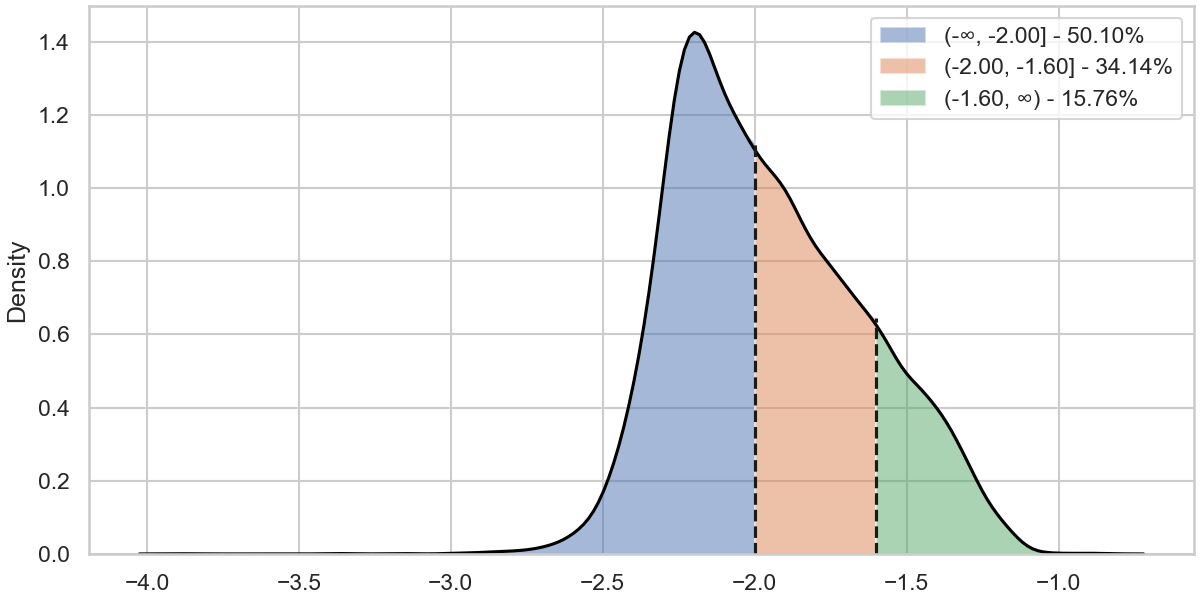

#### Check activity shift between stereoisomers or duplicated molecules in different activity classes defined by the thresholds in paper [Fluetsch et al.2024](https://pubs.acs.org/doi/10.1021/acs.chemrestox.3c00305)

In [27]:
ac_mol_index = [
    16571,
    9114,
    15924,
    7399,
    16593,
    14325,
    13645,
    16675,
    3549,
    1002,
    13773,
    10792,
    16524,
    14840,
    13676,
    16657,
    15764,
    16638,
    15011,
    8239,
    15236,
    12263,
    15952,
    16611,
    8015,
    7923,
    9617,
    16447,
    831,
    14868,
    10417,
    16626,
    15199,
    16259,
    12156,
    15266,
    15216,
    15242,
    9650,
    10436,
    14540,
    8288,
    13901,
    6458,
    14483,
    16651,
    14131,
    10485,
    10730,
    16468,
    11398,
    16542,
    16694,
    13880,
    15652,
    15679,
    8385,
    15288,
    8285,
    14308,
    16731,
    8583,
    10759,
    16492,
    10929,
    13937,
    15263,
    16491,
    13723,
    9936,
    16665,
    7152,
    7039,
    11524,
    16701,
    7755,
    8258,
    14810,
    15492,
    16642,
    10199,
    16432,
    15527,
    9165,
    16685,
    3000,
    8007,
    8122,
    15573,
    16625,
    11485,
    14623,
    13852,
    16465,
    10678,
    15717,
    9624,
    16724,
    14177,
    1344,
    14004,
    10166,
    10383,
    16448,
    8359,
    12176,
    14450,
    16624,
    14857,
    5887,
    16484,
    10876,
    341,
    340,
    16389,
    8742,
    16573,
    2871,
    13902,
    10857,
    14788,
    11476,
    16374,
    12292,
    16619,
    16027,
    16382,
    10102,
    8499,
    14099,
    8786,
    15301,
    8906,
    15251,
    16578,
    12172,
    8473,
    16623,
    13899,
    10941,
    16613,
    10514,
    16697,
    16551,
    15397,
    12274,
    16386,
    12178,
    12134,
    16401,
    14182,
    16444,
    8187,
    12106,
    16462,
    14780,
    9883,
    8534,
    3243,
    5318,
    2686,
    3959,
    3250,
    3616,
    3907,
    128,
    15954,
    14009,
    13818,
    16664,
    14680,
    11313,
    10635,
    15770,
    16585,
    4113,
    11725,
    12288,
    10401,
    16615,
    7754,
    15544,
    14396,
    8200,
    8101,
    14110,
    13874,
    16557,
    8667,
    12295,
    16707,
    7738,
    15238,
    15571,
    15601,
    9967,
    16602,
    9228,
    16575,
    16380,
    12265,
    11198,
    13713,
    11350,
    15894,
    13733,
    16541,
    12181,
    8419,
    817,
    16547,
    8060,
    14439,
    144,
    2781,
    8513,
    10540,
    5170,
    16519,
    16530,
    10317,
    5183,
    4967,
    555,
    16486,
    15662,
    15681,
    11374,
    13674,
    9314,
    10115,
    10487,
    2094,
    15757,
    13841,
    16730,
    10431,
    16521,
    14650,
    14850,
    10830,
    15551,
    15559,
    15966,
    16733,
    11011,
    16566,
    12290,
    16370,
    14878,
    15327,
    8616,
    7813,
    8827,
    9129,
    15311,
    16510,
    6690,
    13683,
    16662,
    11091,
    15988,
    13798,
    8059,
    7880,
    14836,
    12183,
    13996,
    14313,
    16096,
    11152,
    14662,
    3007,
    4644,
    16572,
    7436,
    14784,
    13741,
    16493,
    16597,
    9491,
    8297,
    9275,
    16588,
    15654,
    3791,
    16649,
    14147,
    6836,
    11510,
    14134,
    14867,
    2653,
    14105,
    16580,
    13969,
    14511,
    16590,
    16391,
    882,
    10180,
    14277,
    5898,
    16600,
    8796,
    16560,
    16644,
    10895,
    15910,
    12184,
    16610,
    9111,
    15316,
    9094,
    4616,
    5242,
    12152,
    16411,
    7475,
    16629,
    9471,
    14068,
    9239,
    15535,
    16434,
    16671,
    13765,
    14408,
    15324,
    16302,
    16000,
    16607,
    6226,
    16704,
    13618,
    15475,
    16405,
    7275,
    13642,
    16661,
    13986,
    16435,
    8733,
    13338,
    14077,
    12179,
    7668,
    16576,
    13709,
    8919,
    15788,
    11159,
    16700,
    15280,
    8191,
    12136,
    16614,
    10814,
    8632,
    16446,
    16303,
    16276,
    8496,
    16558,
    10147,
    15239,
    13772,
    16556,
    12126,
    7265,
    14713,
    16643,
    14634,
    3409,
    15568,
    16490,
    14941,
    15791,
    11332,
    8865,
    16517,
    16579,
    7077,
    16205,
    13822,
    13867,
    11296,
    1069,
    8615,
    13918,
    14835,
    16564,
    8032,
    3615,
    2825,
    14112,
    16060,
    11360,
    16605,
    207,
    8226,
    10380,
    11066,
    10476,
    13646,
    10061,
    16640,
    10393,
    13925,
    15793,
    6242,
    14424,
    15358,
    15699,
    16523,
    9252,
    16114,
    2372,
    16436,
    15671,
    7146,
    15916,
    16663,
    15522,
    11741,
    15695,
    10069,
    9160,
    2719,
    2282,
    13983,
    10022,
    16103,
    16650,
    10906,
    16004,
    10583,
    14575,
    11188,
    16400,
    16412,
    10208,
    11145,
    16540,
    10386,
    9890,
    8545,
    14073,
    10697,
    626,
    14797,
    10732,
    14638,
    11503,
    16395,
    12141,
    8011,
    10582,
    13715,
    16390,
    6658,
    11507,
    15588,
    15617,
    5062,
    1148,
    7452,
    16437,
    16439,
    13811,
    12264,
    10591,
    8760,
    15663,
    8986,
    16596,
    14049,
    15801,
    15625,
    16633,
    8980,
    1333,
    10643,
    13812,
    16396,
    16481,
    10114,
    7716,
    14360,
    16325,
    16636,
    13990,
    12099,
    16397,
    16475,
    11511,
    14811,
    13947,
    16373,
    10394,
    54,
    15919,
    9786,
    7833,
    14118,
    15636,
    12123,
    16180,
    8903,
    9128,
    16034,
    16598,
    12205,
    15006,
    13863,
    10955,
    16037,
    16543,
    10174,
]

In [19]:
data_inspection.loc[
    ac_mol_index,
    [
        mol_col,
        "MOL_molhash_id",
        "log_kobs",
        "CLS_log_kobs",
        "split",
    ],
]

,Structure,MOL_molhash_id,log_kobs,CLS_log_kobs,split
16571,O=C(CCNNC(=O)c1ccncc1)NCc2ccccc2,13e570e256510c9436f03e037937c780d8433c48,-1.823909,1.0,test
9114,O=C(CCNNC(=O)c1ccncc1)NCc1ccccc1,13e570e256510c9436f03e037937c780d8433c48,-2.307000,0.0,train
15924,Cl.Fc1ccc([C@H]2CCNCC2COc2ccc3c(c2)OCO3)cc1,11cb6a59f0372b3556ec7e8776b8a0c4cbd07405,-1.819000,1.0,train
7399,Fc1ccc([C@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,0dbe5184d76ed4bc5b9f1a7b1e374e399e6a74d8,-1.737000,1.0,train
16593,Fc1ccc(cc1)[C@@H]2CCNC[C@H]2COc4ccc3OCOc3c4,50a5d92399aa1ca56e375cf1c1df72d1bb8b66e6,-2.301030,0.0,test
...,...,...,...,...,...
13863,COC1C=COC2(C)Oc3c(C)c(O)c4c(O)c(c(C=NN5CCN(C)C...,6e7a9c254d3e44d634af3a510e944757fbfb4305,-2.101000,0.0,train
10955,CO[C@@H]1/C=C\O[C@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,c60126276aa3004550c3ad10eeb5abad0c08c8da,-1.657000,1.0,train
16037,COC1/C=C/OC2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN...,5520829da8087a0b86c0ad712ab107cfd3165888,-1.874000,1.0,train
16543,Nc1nnc(c(N)n1)c2cccc(Cl)c2Cl,36a745677c0649a254f9bbe3bfd4dcc65c7bbb72,-1.920819,1.0,test


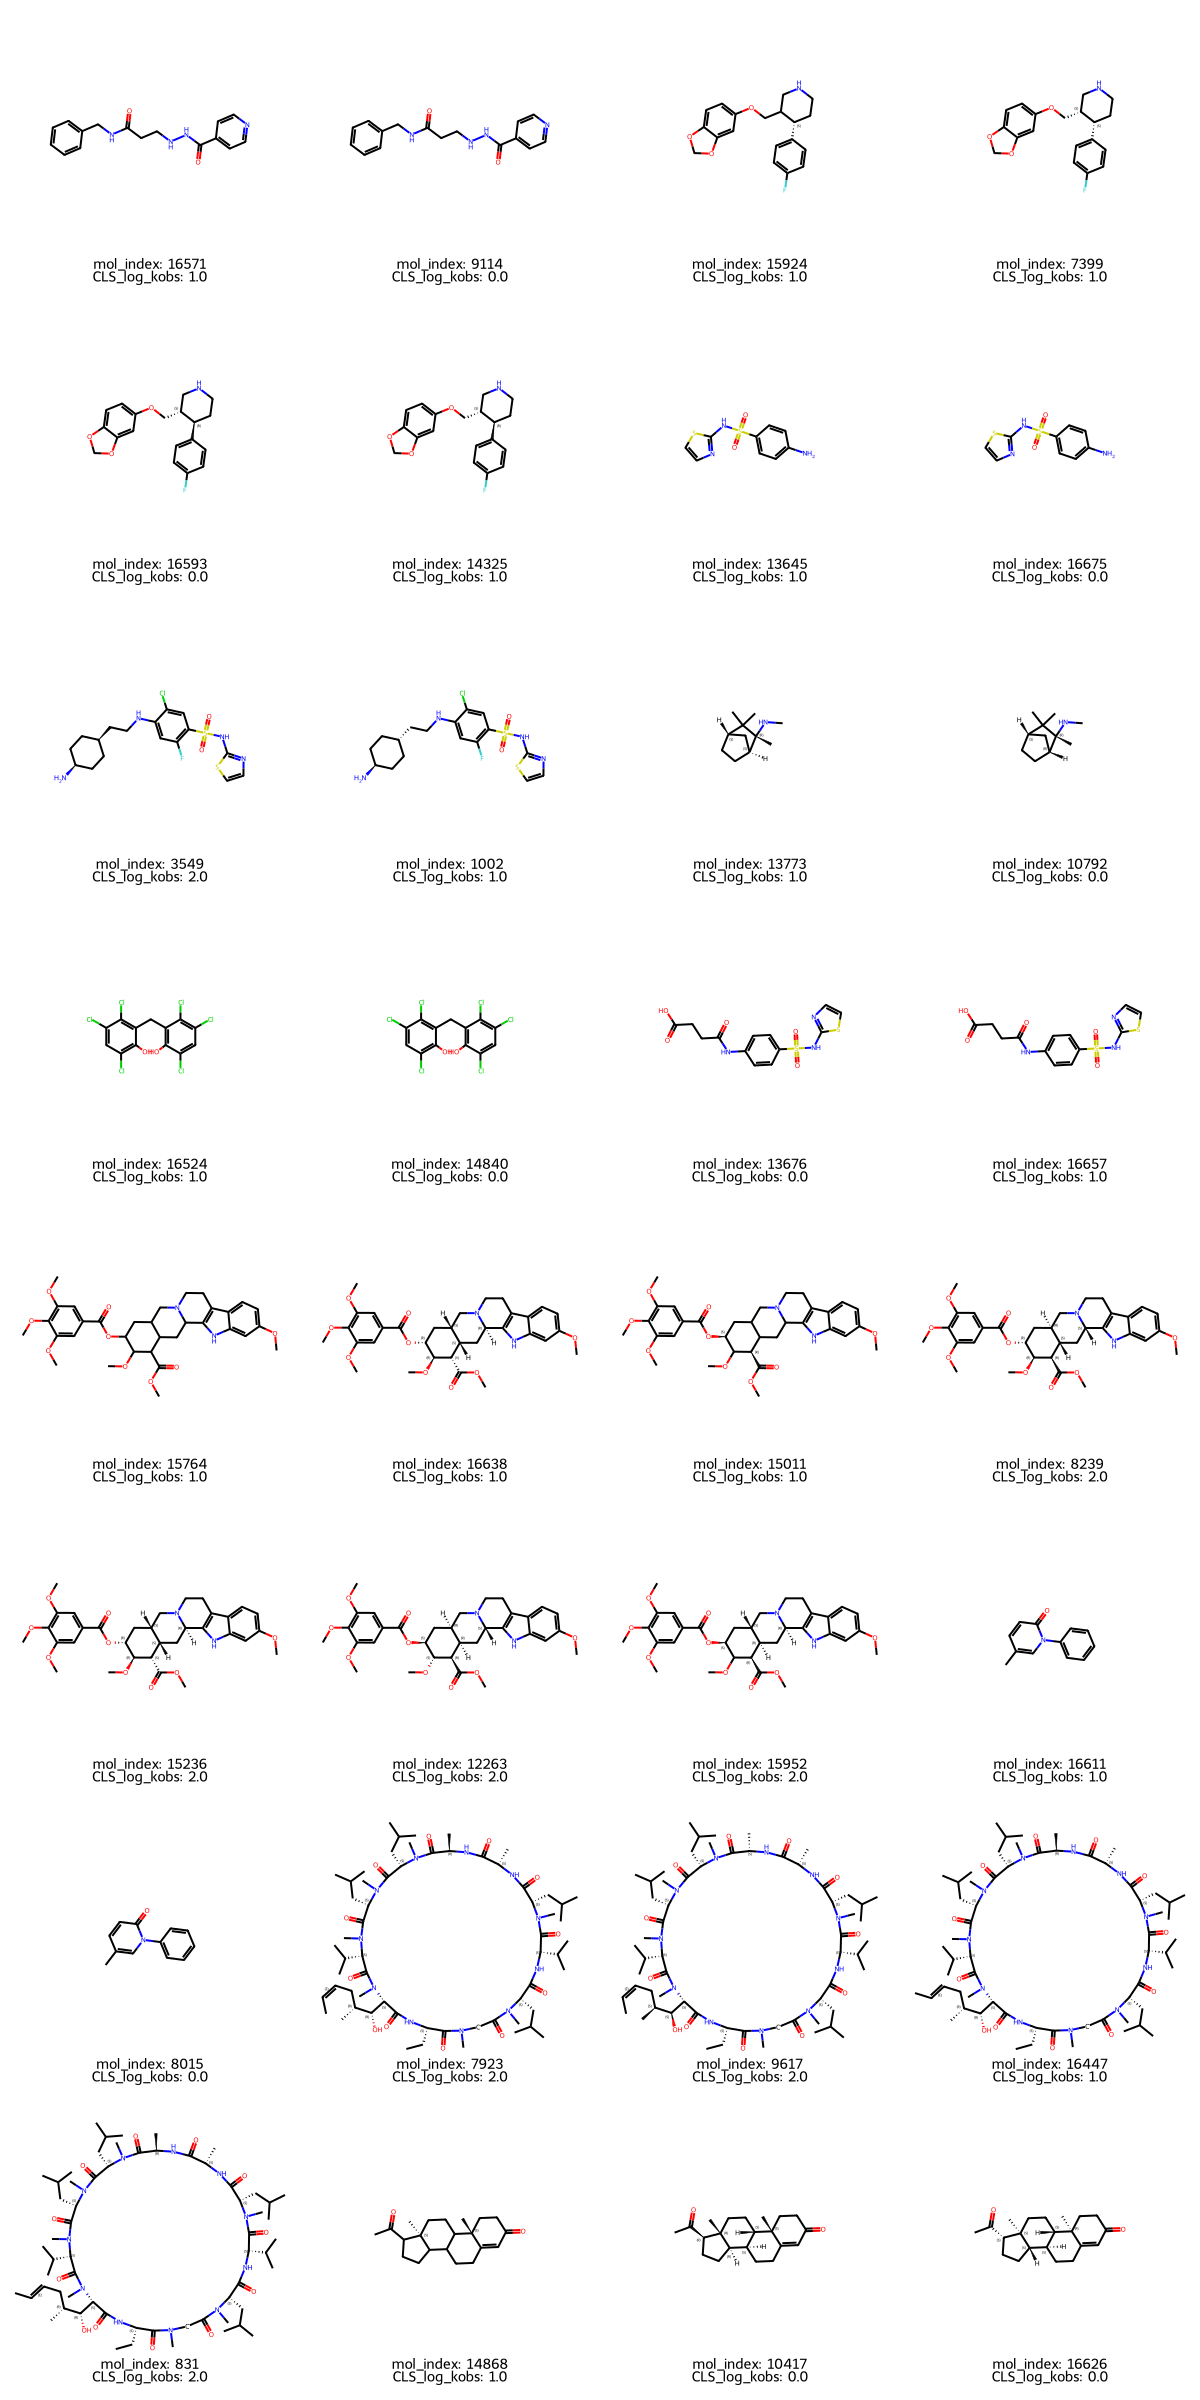

519 molecules were classfied in different CYP3A4 TDI classes. 
- 0: inactivation rate kobs < 0.01 min–1
- 1: weak positive (0.01 ≤ kobs ≤ 0.025 min–1)
- 2 positive (kobs > 0.025 min–1) 
Those molecules were spread across training and testing set. Molecules with close measured values were classified in different clases due to the defined threshold bins. 

Below, we verify the activity shift by zscore of `log_kobs` values.

In [28]:
data_inspection.loc[
    [
        16724,
        14177,
        1344,
        14004,
        9314,
        10115,
        10487,
        2094,
        15757,
        16566,
        12290,
        16370,
        14867,
        2653,
        14105,
        16610,
        9111,
        10394,
        54,
        15919,
        9786,
        7833,
        14118,
        15636,
        12123,
    ],
    [
        mol_col,
        "MOL_molhash_id",
        "log_kobs",
        "CLS_log_kobs",
        "split",
    ],
]

,Structure,MOL_molhash_id,log_kobs,CLS_log_kobs,split
16724,CO[C@H]4C[C@H](O[C@@H]2[C@@H](C)C(=O)O[C@H](C)...,9654c2dcc04af8d60fdc14514a94d9e0501ede4d,-0.872895,2.0,test
14177,COC1C[C@@H](O[C@@H]2C(C)C(=O)OC(C)C(C)[C@H](OC...,e659f2567ad96c3f12ef21983677ae410a5b70c9,-1.742000,1.0,train
1344,CO[C@H]1C[C@H](O[C@@H]2[C@@H](C)C(=O)O[C@H](C)...,9654c2dcc04af8d60fdc14514a94d9e0501ede4d,-1.303000,2.0,train
14004,CO[C@@H]1C[C@H](O[C@H]2[C@@H](C)[C@H](O[C@@H]3...,a59b80dda8123769a1b071eb7440c86069927140,-1.340000,2.0,train
9314,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@H]4CCCN4C...,e401118a9a1147f39e90033fd90b4a21868a4d03,-1.151000,2.0,train
10115,CN1C[C@@H](C(=O)N[C@]2(C)O[C@]3(O)[C@H]4CCCN4C...,47fc3cc062c405b9e78e82b144543b508f62db2c,-1.724000,1.0,train
10487,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@H]4CCCN4C...,9679f067306475221f81a3961e45efa51a3af49f,-1.157000,2.0,train
2094,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,c83d9c2dbcf2a32993a6701eae4fbad6257b7a2a,-1.150000,2.0,train
15757,CN1C[C@H](C(=O)N[C@@]2(C)O[C@@]3(O)C4CCCN4C(=O...,c5f4142868d38fdafc74af6f594f4b62409466bf,-1.869000,1.0,train
16566,CCN(CC)CCOC(=O)C(CC1CCCO1)Cc2cccc3ccccc23,511a4f3fd6799b578a925e68ca67caf596fd3257,-1.301030,2.0,test


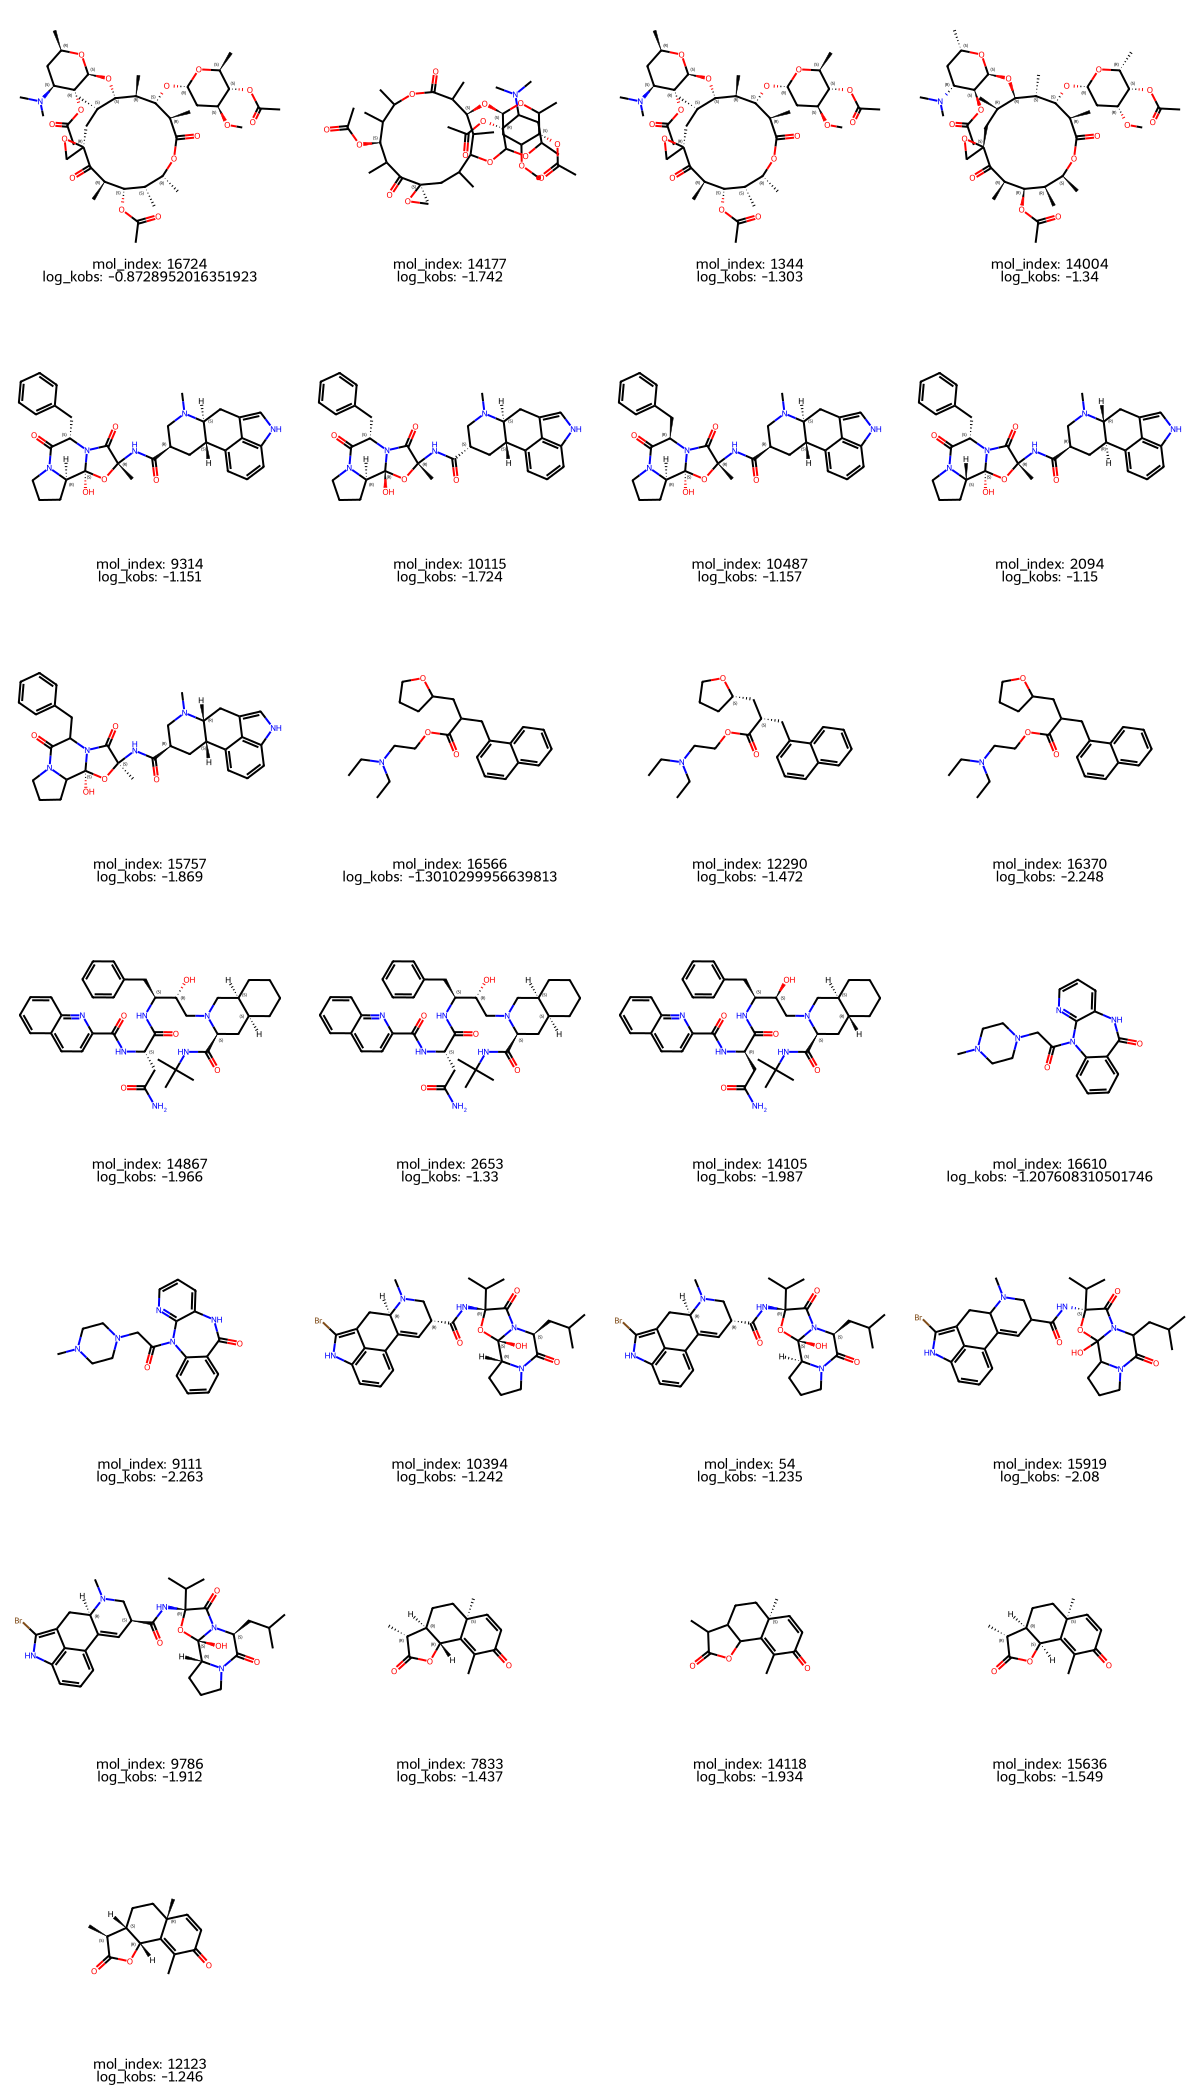

Based on above observation, the stereochemistry of molecule seems play an important role in CYP3A4 inhibition.  

## Export the data with curation columns

In [30]:
fout = f"{gcp_root}/data/curation/CYP_curated.csv"
data_inspection.to_csv(fout)

In [31]:
fout

'gs://polaris-public/polaris-recipes/org-novatis/CYP/data/curation/CYP_curated.csv'